<a href="https://colab.research.google.com/github/Anand7Choudhary/FoodoPedia_/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FoodoPedia

### **Introduction to the Recipe Generation Program**

This program leverages Retrieval-Augmented Generation (RAG) to create customized recipes based on user queries. It combines document retrieval and text generation techniques to provide contextually relevant and creative recipes. By embedding user queries and searching a pre-built knowledge base, the program retrieves the most relevant recipe documents. These documents are then used to generate a new recipe, ensuring it meets the user's specified ingredients and preferences. **The program also includes error handling and filtering to exclude unwanted ingredients, making the recipe generation process both flexible and user-friendly.**


---



# Install necessary packages quietly

To begin, we import a range of libraries essential for data handling, machine learning, and natural language processing. These include standard libraries like pandas and matplotlib, along with specific libraries like datasets from Hugging Face, faiss for efficient similarity search, and torch for deep learning. Additionally, we import components from the Hugging Face transformers library and Langchain for advanced language model interactions.

In [ ]:
# Install necessary packages quietly
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain_community tqdm matplotlib pandas wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 54.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 

In [ ]:
# Import necessary libraries
# Standard libraries
import matplotlib.pyplot as plt
import pandas as pd
# Datasets and progress bar
import datasets
import re
import os
from datasets import Dataset
from tqdm.notebook import tqdm
# FAISS and torch
import faiss
import torch
from collections import Counter
from wordcloud import WordCloud
# Hugging Face transformers
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# Langchain components
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.docstore.document import Document as LangchainDocument
# Typing for type hints
from typing import Optional, List, Tuple

# Load the Dataset
In this section, we load the dataset using the Hugging Face datasets library. We specifically load a subset of the dataset **[Zappandy/recipe_nlg](https://huggingface.co/datasets/Zappandy/recipe_nlg)**, which contains recipes. The code attempts to load 50% of the training split and prints the first five entries to confirm successful loading. Any errors during this process are caught and displayed.

In [ ]:
# Load the dataset
try:
    # Taking 200k data inputs for our model
    ds = datasets.load_dataset("Zappandy/recipe_nlg", split="train[:50%]")
    # Print the first five entries
    print(ds[:5])
    print("Dataset loaded and printed successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'title': ['4-H Special', 'Veal Marsala Scallopini', 'Boiled Cookies', 'Clay Dough', 'Apple Crisp'], 'ingredients': ['1/2 c. uncooked rice<extra_id_99>1 c. water<extra_id_99>1/4 tsp. salt<extra_id_99>1 onion<extra_id_99>1 lb. ground beef<extra_id_99>2 c. canned tomatoes with juice<extra_id_99>1 pt. corn, drained<extra_id_99>2 tsp. salt', '1 lb. thin veal cutlets<extra_id_99>1/3 c. grated Parmesan cheese<extra_id_99>1 clove garlic<extra_id_99>1/4 c. butter<extra_id_99>4 or 5 mushrooms, thinly sliced<extra_id_99>dash of cayenne pepper<extra_id_99>1/4 c. chicken broth<extra_id_99>1/4 c. Marsala wine', '2 c. sugar<extra_id_99>1/2 c. milk<extra_id_99>1/4 lb. margarine or butter<extra_id_99>4 Tbsp. cocoa<extra_id_99>2 1/2 c. oatmeal (quick)<extra_id_99>1/4 c. chopped nuts (optional)<extra_id_99>2 tsp. vanilla<extra_id_99>1/2 c. peanut butter', '3 c. flour<extra_id_99>1 1/2 c. salt<extra_id_99>6 tsp. cream of tartar<extra_id_99>3 c. water<extra_id_99>3 Tbsp. cooking ol<extra_id_99>food colori


# Create the RAW_KNOWLEDGE_BASE List
In this section, we create a list of ***LangchainDocument*** objects from the loaded dataset. Each document in the dataset is processed to extract its title, ingredients, directions, and named entity recognition (NER) data. These details are formatted into a structured string and stored as page_content within a LangchainDocument. Metadata indicating the source of the data is also added to each document. This list forms the raw knowledge base for our recipe generation model.

In [ ]:
# Create the RAW_KNOWLEDGE_BASE list
try:
    RAW_KNOWLEDGE_BASE = [
        LangchainDocument(
            page_content=f"Title: {doc['title']}\nIngredients: {doc['ingredients']}\nDirections: {doc['directions']}\nNER: {doc['NER']}",
            metadata={"source": "recipe_nlg"}
        ) for doc in tqdm(ds)
    ]
    # Example: Display the first LangchainDocument
    print(RAW_KNOWLEDGE_BASE[0])
    print("RAW_KNOWLEDGE_BASE created and first document displayed successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


  0%|          | 0/4000 [00:00<?, ?it/s]

page_content='Title: 4-H Special\nIngredients: 1/2 c. uncooked rice<extra_id_99>1 c. water<extra_id_99>1/4 tsp. salt<extra_id_99>1 onion<extra_id_99>1 lb. ground beef<extra_id_99>2 c. canned tomatoes with juice<extra_id_99>1 pt. corn, drained<extra_id_99>2 tsp. salt\nDirections: Put onion and beef in skillet; cook over moderate heat.<extra_id_99>Stir and turn until meat has browned.<extra_id_99>Stir tomatoes, corn, rice and salt into meat.<extra_id_99>Pour into greased casserole dish and bake for 30 minutes at 350°.\nNER: rice, water, salt, onion, ground beef, tomatoes, corn, salt' metadata={'source': 'recipe_nlg'}
RAW_KNOWLEDGE_BASE created and first document displayed successfully.


## Analyze Ingredient Entities in Recipe Data


This section ensures that a directory named "***images***" exists to store images generated or used in our project. The code checks if the directory already exists, and if not, it creates the directory. Any issues encountered during this process are caught and displayed.

In [ ]:
# Create the "images" directory if it doesn't exist to store our images
try:
    images_dir = "images"
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
        print(f"Directory '{images_dir}' created successfully!")
    else:
        print(f"Directory '{images_dir}' already exists.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Directory 'images' created successfully!


In this section, we analyze the named entities extracted from our recipe dataset. Named Entity Recognition (NER) helps in identifying and categorizing key ingredients and elements within the recipes. We use the ***re*** library to extract entities, and ***Counter*** to count the occurrences of each entity. The most common entities are then visualized using a bar plot.

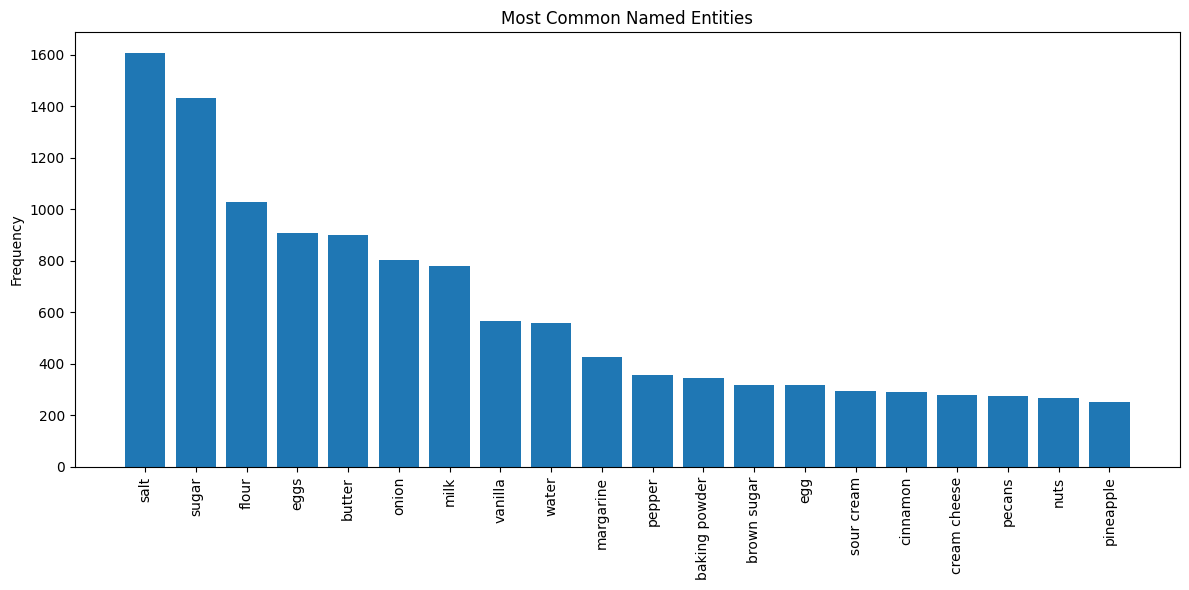

In [ ]:
# Extract all named entities (NER)
entities = []
for doc in RAW_KNOWLEDGE_BASE:
    entities.extend(re.findall(r'NER: (.*)', doc.page_content))

# Create a Counter object and extract the most common entities
entity_counter = Counter()
for entity_str in entities:
    entity_counter.update(entity_str.split(', '))

# Extract the most common entities
most_common_entities = entity_counter.most_common(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
fig = plt.gcf()
fig.set_facecolor('white')
plt.bar(range(len(most_common_entities)), [count for _, count in most_common_entities])
plt.xticks(range(len(most_common_entities)), [entity for entity, _ in most_common_entities], rotation=90)
plt.ylabel('Frequency')
plt.title('Most Common Named Entities')
plt.tight_layout()
plt.savefig('images/most_common_ingredients.png', dpi=300, bbox_inches='tight')
plt.show()

# Initialize the Embedding Model

This section defines markdown separators to preprocess the text data, specifies the embedding model **[thenlper/gte-small](https://huggingface.co/thenlper/gte-small)***, and initializes it using the ***HuggingFaceEmbeddings*** class. The embeddings are normalized for ***cosine similarity*** to ensure consistent and comparable results. Any errors encountered during this process are caught and displayed.

Why this?

*   model is chosen for its efficiency and effectiveness in generating high-quality embeddings.
*   suitable for tasks involving text similarity and retrieval.

In [ ]:
try:
    # Define markdown separators for text splitting
    MARKDOWN_SEPARATORS = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]
    # Define the embedding model name
    EMBEDDING_MODEL_NAME = "thenlper/gte-small"
    # Initialize the embedding model
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        # Normalize embeddings for cosine similarity
        encode_kwargs={"normalize_embeddings": True},
    )
    print("Embedding model initialized successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model initialized successfully.


### Print Embedding values

We print the embedding vector values for 5 words with first 5 vector score. Our original torch size is : [5, 384]

In [ ]:
# Initialize the tokenizer and embedding model
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)
# Define a regular expression pattern to extract words
word_pattern = r'\b\w+\b'
# Create a list to store all words
all_words = []

# Iterate over each document in the dataset
for doc in RAW_KNOWLEDGE_BASE:
    # Extract the page content
    content = doc.page_content
    # Find all words in the content using the regular expression pattern
    words = re.findall(word_pattern, content, re.IGNORECASE)
    # Add the extracted words to the list
    all_words.extend(words)
# Convert the list of words to a set to remove duplicates
unique_words = set(all_words)
# Select the first 5 unique words
first_5_words = list(unique_words)[:5]
# Retrieve the word embeddings
embeddings = [embedding_model.embed_query(word) for word in first_5_words]
# Convert embeddings to PyTorch tensors
embeddings = [torch.tensor(emb) for emb in embeddings]
# Create the embedding matrix
embedding_matrix = torch.stack(embeddings)
for i, word in enumerate(first_5_words):
    print(f"Word: {word}")
    print(f"Embedding: {embedding_matrix[i][:5]}")
    print("-" * 20)

Word: crispums
Embedding: tensor([0.0035, 0.0141, 0.0662, 0.0196, 0.0168])
--------------------
Word: Lafollette
Embedding: tensor([-0.0191, -0.0275,  0.0505, -0.0011,  0.0573])
--------------------
Word: spiked
Embedding: tensor([-0.0395,  0.0037,  0.0060, -0.0283,  0.0370])
--------------------
Word: C
Embedding: tensor([-0.0395, -0.0141,  0.0360,  0.0176, -0.0177])
--------------------
Word: Okra
Embedding: tensor([-0.0496, -0.0637,  0.0347, -0.0162,  0.0560])
--------------------


### Generate and Display Word Cloud for Ingredients

This section extracts all ingredient mentions from the RAW_KNOWLEDGE_BASE and generates a word cloud to visualize the frequency and importance of different ingredients in the dataset. The word cloud helps in identifying the most commonly used ingredients in the recipes.

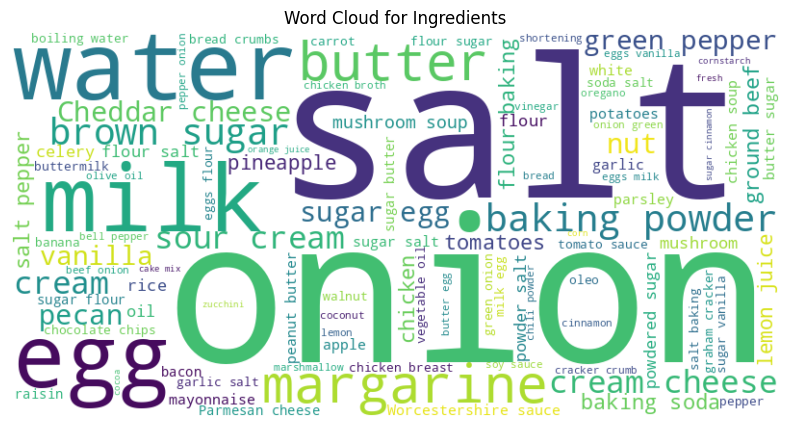

In [ ]:
# Extract all ingredients for the word cloud
ingredients = []
for doc in RAW_KNOWLEDGE_BASE:
    ingredients.extend(re.findall(r'NER: (.*)', doc.page_content, re.DOTALL))

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(ingredients))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ingredients')
plt.savefig('images/word_cloud_ingredients.png', dpi=300, bbox_inches='tight')
plt.show()

# Split Documents into Chunks

This section defines a function, split_documents, to split large documents into smaller chunks suitable for processing by language models. The function initializes a tokenizer and uses the ***RecursiveCharacterTextSplitter*** to split the text based on a specified chunk size and overlap. It processes each document in the knowledge base, ensuring unique and manageable text segments. Any errors during the process are caught and displayed. The function is then used to split the documents in RAW_KNOWLEDGE_BASE into chunks of 512 tokens (based on computing resource avaliable), making them ready for further analysis.

**GPU runtime: 10mins**

In [ ]:
# Function to split documents into chunks
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    try:
        # Initialize the tokenizer
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Initialize the text splitter
        text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
            tokenizer,
            chunk_size=chunk_size,
            chunk_overlap=int(chunk_size / 10),
            add_start_index=True,
            strip_whitespace=True,
            separators=MARKDOWN_SEPARATORS,
        )

        docs_processed = []
        for doc in knowledge_base:
            docs_processed += text_splitter.split_documents([doc])

        # Remove duplicates
        unique_texts = {}
        docs_processed_unique = []
        for doc in docs_processed:
            if doc.page_content not in unique_texts:
                unique_texts[doc.page_content] = True
                docs_processed_unique.append(doc)

        return docs_processed_unique
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []

# Split the documents using the defined function
try:
    docs_processed = split_documents(
        512,  # We choose a chunk size adapted to our model
        RAW_KNOWLEDGE_BASE,
        tokenizer_name=EMBEDDING_MODEL_NAME,
    )
    print("Documents processed successfully.")
except Exception as e:
    print(f"An error occurred while splitting documents: {e}")

Documents processed successfully.



# Create and Save FAISS Vector Store

In this section, we create a ***FAISS vector*** store using the processed document chunks. The FAISS.from_documents function converts the list of LangchainDocument objects into vector representations using the previously initialized embedding model. We use ***cosine similarity*** as the distance strategy because it is effective in measuring the similarity between high-dimensional vectors by focusing on the orientation rather than the magnitude. After creating the vector store, we print the number of documents processed. To ensure the vector store can be reused later, we save the FAISS index to disk using ***faiss.write_index***. This operation is wrapped in a try-except block to handle any potential errors, ensuring robust error reporting if the save operation fails.

**GPU runtime: 18mins**

In [ ]:
# Create the FAISS vector store from the processed documents
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed,  # List of LangchainDocuments
    embedding_model,  # Embedding model to generate vectors
    distance_strategy=DistanceStrategy.COSINE  # Use cosine similarity
)
print("Vector store created with", len(docs_processed), "documents.")

# Save the FAISS index to disk
try:
    faiss.write_index(KNOWLEDGE_VECTOR_DATABASE.index, "vector_db.index")
    print("FAISS index saved successfully.")
except Exception as e:
    print(f"An unexpected error occurred while saving the FAISS index: {e}")

Vector store created with 4016 documents.
FAISS index saved successfully.


### Visualize Document Lengths in Tokens

This section visualizes the distribution of document lengths in the knowledge base in terms of token count. Using the tokenizer from the embedding model, we encode each document to determine its length in tokens. A histogram is then plotted to show the frequency distribution of these token counts, helping to understand the typical size of the document chunks.

  0%|          | 0/4016 [00:00<?, ?it/s]

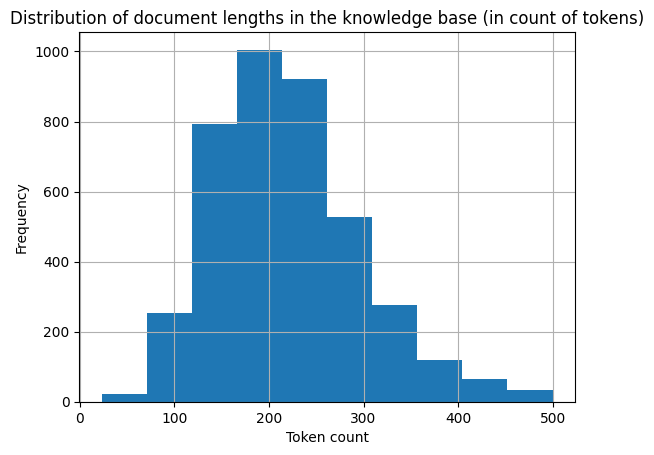

In [ ]:
# Visualize the chunk sizes we would have in tokens
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.savefig('images/document_length_over_token.png', dpi=300, bbox_inches='tight')
plt.show()

# Initialize and Configure Reader Model

In this section, we set up a reader model for generating text. We chose the **[HuggingFaceH4/zephyr-7b-beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta)**. After loading the model, we initialize the tokenizer, which prepares the text data for the model. We then create a text-generation pipeline that includes the model and tokenizer, with settings to control the style and length of the generated text. This setup ensures that our system can generate high-quality text efficiently, handling various text generation tasks with ease. Error handling is included to catch and report any issues during the setup process.

Why this?

*   Has balance of performance and efficiency
*   Is configured to use 4-bit precision, which helps in running it efficiently even on hardware with limited resources.
*   Can take 4000+ tokens, so I can provide multiple context, upto 20 recipes!!!

In [ ]:
# Initialize and Configure Reader Model
try:
    READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    # Load the model with quantization configuration
    try:
        model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"An unexpected error occurred while loading the model: {e}")

    # Initialize the tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)
        print("Tokenizer initialized successfully.")
    except Exception as e:
        print(f"An unexpected error occurred while initializing the tokenizer: {e}")

    # Create the pipeline
    try:
        READER_LLM = pipeline(
            model=model,
            tokenizer=tokenizer,
            task="text-generation",
            do_sample=True,
            temperature=0.2,
            repetition_penalty=1.1,
            return_full_text=False,
            max_new_tokens=1000,
        )
        print("Pipeline created successfully.")
    except Exception as e:
        print(f"An unexpected error occurred while creating the pipeline: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded successfully.


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Tokenizer initialized successfully.
Pipeline created successfully.



# Create a General Prompt for the LLM to Process

In this section, we create a ***structured prompt*** for the language model (LLM) to process, guiding it to generate responses in a specific format. The prompt instructs the LLM to take on the persona of a professional chef with a sense of humor, incorporating creative language, emojis, and jokes into recipe directions. The model is directed to follow particular rules based on the nature of the question: if it specifies using only certain ingredients, or if it doesn't specify, the model should provide a complete recipe or a plausible one with placeholders for missing ingredients. If the context isn't sufficient for a recipe, the model should respond with a witty remark. For non-recipe questions, the model is instructed to provide appropriate, humorous responses or acknowledge the lack of information in a funny way.

In [ ]:
# Create a general prompt for the LLM to process
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are a professional chef with a great sense of humor. When generating recipes, use creative and fun language. but do not use any hashtags. Follow these instructions:

Using the information contained in the context, provide a comprehensive answer to the question. Respond only to the question asked, and make sure the response is relevant to the question. If the question is related to recipes:

- If the query specifies "only [ingredients]" or "[ingredients] only", generate a recipe using strictly only those ingredients mentioned after or before the word "only". If the context does not contain enough information to generate a recipe with only those ingredients, state that the information is not available with a witty remark.

- If the query does not specify "only [ingredients]":
    - If all the ingredients and directions are available in the context, provide the recipe title, ingredients, and directions.
    - If some ingredients are missing from the context, generate a plausible recipe based on the available information, with placeholders for the missing ingredients.
    - If the context does not contain enough information to generate a recipe, state that the information is not available with a witty remark.

If the question is not related to recipes, provide an appropriate response based on the context, using your creative and humorous language style. If the answer cannot be deduced from the context, simply state that the information is not available in a funny way. DO not provide any ingredients, directions or title"""
    },
    {
        "role": "user",
        "content": """Context: {context} Question: {question}"""
    }
]

# Apply the prompt template using the tokenizer
try:
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
        prompt_in_chat_format, tokenize=False, add_generation_prompt=True
    )
    print("Prompt template applied successfully.")
except Exception as e:
    print(f"An unexpected error occurred while applying the prompt template: {e}")

Prompt template applied successfully.


# Embed the Query, Retrieve, and Filter Recipes

In this section, we define functions to embed a user query, retrieve similar recipes from our dataset, and filter out recipes containing specified excluded ingredients. The embedQuery_similarDocuments function first embeds the user query using the embedding model. It also checks for any ingredients the user wants to exclude from the results by searching for phrases like "not", "excluding", "except", "without", or "no". The filter_recipes function is then used to exclude recipes containing any of the specified ingredients. Finally, the function prints the filtered recipes for the user.

In [ ]:
# Embed the query and get the similar recipes from out dataset
def filter_recipes(recipes, excluded_ingredients):
    filtered_recipes = []
    for recipe in recipes:
        recipe_text = recipe.page_content.lower()
        exclude = False
        for ingredient in excluded_ingredients:
            if re.search(r'\b' + ingredient.lower() + r'\b', recipe_text):
                exclude = True
                break
        if not exclude:
            filtered_recipes.append(recipe)
    return filtered_recipes

def embedQuery_similarDocuments(query):
    # Embed the query
    query_embedding = embedding_model.embed_query(query)
    excluded_ingredients = []
    excluded_pattern = r'(not|excluding|except|without|no)\s+([\w\s,]+\s*(and|or)\s*[\w\s,]+)'
    match = re.search(excluded_pattern, query, re.IGNORECASE)
    if match:
        ingredients_str = match.group(2)
        ingredients_str = re.sub(r'\s+and\s+', ' or ', ingredients_str, flags=re.IGNORECASE)
        excluded_ingredients = [item.strip() for item in re.split(r'\s+or\s+', ingredients_str)]
        query = re.sub(excluded_pattern, '', query, flags=re.IGNORECASE).strip()
    # Retrieve similar documents
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=query, k=10)
    if excluded_ingredients:
        retrieved_docs = filter_recipes(retrieved_docs, excluded_ingredients)
    if not retrieved_docs:
        print("Sorry, I couldn't find any relevant recipes based on your query and exclusions.")
    else:
        print("=================================================================================")
        print("============================ Top related documents ==============================")
        print("=================================================================================")
        # Display the results
        for result in retrieved_docs:
          print(result.page_content)
          print("---")  # Add a separator between results for better readability
    return retrieved_docs


# Function to Generate New Recipe
This section defines a function, getRecipe, which generates a new recipe based on a user query and a set of retrieved documents. The function compiles the text from the retrieved documents to create a context, then formats a final prompt using a predefined prompt template. This prompt is fed into the language model pipeline to generate a creative and contextually relevant recipe.

In [ ]:
# Function to generate new recipe
def getRecipe(query,retrieved_docs):
  # We only need the text of the documents
  retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
  context = "\nExtracted documents:\n"
  context += "".join([f"Document {str(i)}:::\n" + doc for i,
                      doc in enumerate(retrieved_docs_text)])
  final_prompt = RAG_PROMPT_TEMPLATE.format(question=query, context=context)
  # Redact an answer
  answer = READER_LLM(final_prompt)[0]["generated_text"]
  print(answer)

# Define and Process the Query
In this section, we define a specific query asking for recipes that include only mushrooms, onions, and tomatoes. The query is then processed to retrieve relevant documents from our dataset. The embedQuery_similarDocuments function is used to embed the query into a numerical vector and perform a similarity search in the FAISS vector store. This search identifies the top documents that match the query criteria. The function also filters out any recipes that do not strictly use the specified ingredients. If successful, the retrieved documents are printed, allowing us to review the most relevant recipes based on the given query. This process ensures that the user receives tailored recipe suggestions that match their specified ingredient constraints.

In [ ]:
# Define the query
query = "Chocolate Cookie please!"

try:
    # Retrieve similar documents based on the query
    retrieved_docs = embedQuery_similarDocuments(query)
except Exception as e:
    print(f"An unexpected error occurred while retrieving documents: {e}")

============================ Top related documents ==============================
Title: Alexis' Brown Sugar Chocolate Chip Cookies
Ingredients: 1 lb. unsalted butter<extra_id_99>3 c. brown sugar<extra_id_99>4 eggs<extra_id_99>2 tsp. vanilla<extra_id_99>3 1/2 c. all-purpose flour<extra_id_99>1 1/2 tsp. salt<extra_id_99>2 tsp. soda<extra_id_99>1 1/2 c. chocolate chips
Directions: Preheat oven to 375°.<extra_id_99>Cream the butter until smooth.<extra_id_99>Add the sugars.<extra_id_99>Beat in the eggs and vanilla.<extra_id_99>Sift the flour, salt and soda.<extra_id_99>Beat into the butter mixture.<extra_id_99>Add the chocolate chips. Drop 2 to 3 tablespoon of batter onto greased baking sheet 2 inches apart.<extra_id_99>Bake 8 minutes.<extra_id_99>Remove from pans with spatula and cool on racks.<extra_id_99>Makes about 30 cookies.
NER: unsalted butter, brown sugar, eggs, vanilla, flour, salt, soda, chocolate chips
---
Title: Hershey Chewy Chocolate Cookies
Ingredients: 1 1/4 c. butter or m

## Generate Recipe Based on the Query and Retrieved Documents
In this section, we generate a recipe using the query and the retrieved documents. The getRecipe function compiles the text from these documents into a structured prompt and uses the language model to generate the recipe. The generated recipe is printed, along with the retrieved documents for context and reference.


In [ ]:
# Generate recipe based on the query and retrieved documents
try:
  recipe = getRecipe(query, retrieved_docs)
except Exception as e:
  print(f"An unexpected error occurred while generating the recipe: {e}")

Absolutely! Here's a delicious chocolate cookie recipe for you:

Title: Fudgy Brownie Cookies
Ingredients:
- 1/2 cup unsalted butter
- 2 cups granulated sugar
- 3/4 cup unsweetened cocoa powder
- 1/2 cup vegetable oil
- 4 large eggs
- 2 teaspoons vanilla extract
- 2 cups all-purpose flour
- 2 teaspoons baking powder
- 1 teaspoon salt
- 2 cups semisweet chocolate chips

Directions:
1. Preheat your oven to 350°F (180°C). Line two baking sheets with parchment paper.
2. In a medium saucepan, melt the butter over low heat. Remove from heat and add the sugar and cocoa powder. Stir until well combined.
3. Add the vegetable oil, eggs, and vanilla extract. Mix until everything is incorporated.
4. In a separate bowl, whisk together the flour, baking powder, and salt. Gradually add this mixture to the chocolate mixture, stirring until just combined.
5. Fold in the chocolate chips.
6. Using a cookie scoop or spoon, form the dough into balls and place them on the prepared baking sheets, leaving abo

### Here are some of the queries you can try to check on the models behaviour:


> **`The Model Works with the negative ingredients as well (not|excluding|except|without|no)`**



1. Any recipe with mushrooms, onions, tomatoes and without beef, chicken or pork

2. Recipe with only chicken

3. Recipes using only eggs, spinach, and avocado

4. Dessert recipes without chocolate or nuts for allergies

5. Recipe for Chocolate cookie without eggs

6. Where is the FIFA world cup 2026

7. Something with ice-cream and ketchup
---



